In [1]:
import uproot
import numpy as np
import os
import matplotlib.pyplot as plt
import mplhep as hep
import glob
from scipy.stats import beta

def clopper_pearson_interval(k, n, alpha=0.05):
    lower_bound = beta.ppf(alpha / 2, k, n - k + 1)
    upper_bound = beta.ppf(1 - alpha / 2, k + 1, n - k)
    return lower_bound, upper_bound


# Ntuple distribution checks

In [ ]:
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm

# Function to load data
def load_data(file_paths):
    jet1_pt_list = []
    jet1_m_list = []
    weights_list = []

    
    for file_path in file_paths:
        file = uproot.open(file_path)
        
        # Check if the "Nominal" tree is in the file
        if "Nominal" not in file:
            print(f"Skipping file {file_path} because it does not contain a 'Nominal' tree.")
            continue 
        
        tree = file["Nominal"]
        
        # Read the necessary branches
        jet1_pt = tree["Jet1_pT"].array(library="np")
        jet1_m = tree["Jet1_M"].array(library="np")
        weights = tree["weight"].array(library="np")  # Adjust this to your weight branch name

        
        jet1_pt_list.append(jet1_pt)
        jet1_m_list.append(jet1_m)
        weights_list.append(weights)
        
        
    jet1_pt = np.concatenate(jet1_pt_list)
    jet1_m = np.concatenate(jet1_m_list)
    weights = np.concatenate(weights_list)

    return jet1_pt, jet1_m, weights

# Find all directories containing '36470*' and get .root files inside them
base_path = "/fs/ddn/sdf/group/atlas/d/zzheng/ggH/ntuple/All/"
pattern = os.path.join(base_path, "*20e*36470*/*.root")
file_paths = glob.glob(pattern, recursive=True)

if not file_paths:
    print("No matching files found.")


# Load data
jet1_pt, jet1_m, weights = load_data(file_paths)

# Create the corner plot
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], wspace=0.15, hspace=0.15)

# Axis limits
pt_min, pt_max = 250, 800  # Set your desired limits for Jet1_pT
m_min, m_max = 0, 250     # Set your desired limits for Jet1_M


# Top-left: 1D distribution of Jet1_pT
ax_hist_pt = plt.subplot(gs[0, 0])
ax_hist_pt.hist(jet1_pt, bins=50, range=(pt_min, pt_max), histtype='step', color='black',weights=weights)
ax_hist_pt.set_xlim(pt_min, pt_max)
ax_hist_pt.set_ylabel('Counts')
ax_hist_pt.set_yscale('log')  # Set y-axis to log scale
ax_hist_pt.tick_params(axis='x', labelbottom=False)

# Center: 2D distribution of Jet1_pT vs Jet1_M
ax_scatter = plt.subplot(gs[1, 0])
h, xedges, yedges = np.histogram2d(jet1_pt, jet1_m, bins=[50, 50], range=[[pt_min, pt_max], [m_min, m_max]],weights=weights)
im = ax_scatter.imshow(h.T, origin='lower', aspect='auto', extent=[pt_min, pt_max, m_min, m_max], cmap='Blues', norm=LogNorm())  # Changed to heatmap with log scale
ax_scatter.set_xlim(pt_min, pt_max)
ax_scatter.set_ylim(m_min, m_max)
ax_scatter.set_xlabel(r'Jet 1 $p_T$ [GeV]')
ax_scatter.set_ylabel(r'Jet 1 $M$ [GeV]')

# Bottom-right: 1D distribution of Jet1_M
ax_hist_m = plt.subplot(gs[1, 1])
ax_hist_m.hist(jet1_m, bins=50, range=(m_min, m_max), histtype='step', orientation='horizontal', color='black',weights=weights)
ax_hist_m.set_ylim(m_min, m_max)
ax_hist_m.set_xlabel('Counts')
ax_hist_m.set_xscale('log')  # Set x-axis to log scale
ax_hist_m.tick_params(axis='y', labelleft=False)

# Add color bar to the right of all plots
cbar_ax = fig.add_axes([0.98, 0.17, 0.02, 0.55])  # [left, bottom, width, height]
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label('Counts')

plt.show()

# Efficiency vs pT

In [2]:
mass_cut = 0

def load_data_with_cuts_pT(file_paths):
    jet1_pt_list = []
    pass_hlt_dict = {}
    nMuons_list = []
    nLargeRJets_list = []
    Jet1_M_list = []
    weights_list = []

    for file_path in file_paths:
        # Open the ROOT file and read the tree
        file = uproot.open(file_path)
        
        # Check if the "Nominal" tree is in the file
        if "Nominal" not in file:
            print(f"Skipping file {file_path} because it does not contain a 'Nominal' tree.")
            continue        
        
        tree = file["Nominal"]

        # Read the necessary branches
        jet1_pt = tree["Jet1_pT"].array(library="np")
        nMuons = tree["nMuons"].array(library="np")
        nLargeRJets = tree["nLargeRJets"].array(library="np")
        Jet1_M = tree["Jet1_M"].array(library="np")
        weights = tree["weight"].array(library="np")  
        
        # Define selection cuts (e.g., nMuons > 0 and Jet1_M > 100)
        selection_mask = (nMuons >= 0) & (nLargeRJets>=1) & (Jet1_M > mass_cut)

        # Apply the selection mask to the data
        jet1_pt_list.append(jet1_pt[selection_mask])
        nMuons_list.append(nMuons[selection_mask])
        nLargeRJets_list.append(nLargeRJets[selection_mask])
        Jet1_M_list.append(Jet1_M[selection_mask])
        weights_list.append(weights[selection_mask])

        # Read all branches starting with "passHLT_" and apply the mask
        for branch in tree.keys():
            if branch.startswith("passHLT_"):
                #if "INF" not in branch:
                if "_" not in branch:     
                    continue # Skip branches that do not contain "INF"
                else:    
                    if branch not in pass_hlt_dict:
                        pass_hlt_dict[branch] = []
                    pass_hlt_dict[branch].append(tree[branch].array(library="np")[selection_mask])

    # Combine arrays from different files
    jet1_pt = np.concatenate(jet1_pt_list)
    weights = np.concatenate(weights_list)

    for key in pass_hlt_dict.keys():
        pass_hlt_dict[key] = np.concatenate(pass_hlt_dict[key])

    return jet1_pt, weights, pass_hlt_dict



In [3]:
def calculate_efficiency_pT(pass_hlt, jet1_pt,weights, thresholds):
    efficiency = []
    lower_errors = []
    upper_errors = []

    for threshold in thresholds:
        #passing_events = np.sum((jet1_pt > threshold) & (pass_hlt == 1))
        #total_events = np.sum(jet1_pt > threshold)
        
        selection_mask = jet1_pt > threshold
        passing_mask = (jet1_pt > threshold) & (pass_hlt == 1)

        total_events = np.sum(weights[selection_mask])
        passing_events = np.sum(weights[passing_mask])        
        
        
        if total_events > 0:
            eff = passing_events / total_events
            #err = np.sqrt(eff * (1 - eff) / total_events)
            #efficiency.append(eff)
            #errors.append(err)
            lower, upper = clopper_pearson_interval(passing_events, total_events)
            efficiency.append(eff)
            lower_errors.append(eff - lower)
            upper_errors.append(upper - eff)
            
        else:
            efficiency.append(0)
            #errors.append(0)
            lower_errors.append(0)
            upper_errors.append(0)

    return np.array(efficiency),np.array(lower_errors), np.array(upper_errors)


In [4]:

def trigger_efficiency_pT(input_path,textlabel):
    # Set the ATLAS Style
    hep.style.use("ATLAS")


  # Specify the base path directly
    base_path = "/fs/ddn/sdf/group/atlas/d/zzheng/ggH/ntuple/All/"

    # If input_path is a directory, find all matching .root files
    #if os.path.isdir(os.path.join(base_path, input_path)):
    #    file_paths = glob.glob(os.path.join(base_path, input_path, "*.root"))
    #else:
    #    file_paths = [os.path.join(base_path, input_path)]

    pattern = os.path.join(base_path, input_path)
    file_paths = glob.glob(pattern, recursive=True)    
    
    # Load data from ROOT files with selection cuts
    jet1_pt,weights, pass_hlt_dict = load_data_with_cuts_pT(file_paths)

    # Define thresholds for Jet1_pT
    thresholds = np.linspace(np.min(jet1_pt), 1000, 30)

    # Create a directory to store the efficiency plots
    os.makedirs("efficiency_plots_jet1_pT_INF", exist_ok=True)

    # Colors for different triggers
    #colors = ['r', 'b', 'g', 'm', 'c', 'orange', 'violet', 'springgreen']
    colors = ['r', 'b', 'g', 'm', 'c', 'orange', 'violet', 'springgreen', 
          'yellow', 'brown', 'pink', 'grey', 'navy', 'lime', 'cyan', 
          'purple', 'teal', 'gold', 'darkred', 'lightblue']
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot efficiency for each passHLT branch containing "INF"
    for idx, (branch, pass_hlt) in enumerate(pass_hlt_dict.items()):
        #if "INF" in branch:
        if "_" in branch:     
            #efficiency, errors = calculate_efficiency_pT(pass_hlt, jet1_pt, weights, thresholds)
            efficiency, lower_errors, upper_errors = calculate_efficiency_pT(pass_hlt, jet1_pt, weights, thresholds)
            
            # Plot the graph with markers and error bars
            color = colors[idx % len(colors)]
            ax.errorbar(thresholds, efficiency, yerr=[lower_errors, upper_errors], fmt='o', label=f'{branch}', color=color)

            # Plot the line through the points
            ax.plot(thresholds, efficiency, color=color)

    # Set axis titles
    ax.set_xlabel("Jet1 $p_\mathcal{T}$")
    ax.set_ylabel('Trigger Efficiency')

    # Add the ATLAS Label
    #hep.atlas.text("Internal", loc=1)
    hep.atlas.label(loc=1,data='true',label="Internal",lumi=139)

    
    #ax.text(0.2, 0.86, "#sqrt{s} = 13 TeV, 139 fb^{-1}", fontsize=12, transform=ax.transAxes)

    # Add the mass cut text
    ax.text(0.05, 0.83, f"Jet1 M > {mass_cut} GeV", fontsize=14, transform=ax.transAxes)
    ax.text(0.05, 0.78, f"{textlabel}", fontsize=14, transform=ax.transAxes)

    # Add legend
    ax.legend(bbox_to_anchor=(0.15, 0.10,0.3,0.3),fontsize=14,loc='lower left')
    #ax.legend(bbox_to_anchor=(0.55, 0.2, 0.85, 0.6),fontsize=14)

    # Save the plot as a PDF
    plt.savefig("efficiency_plots_jet1_pT_INF/INF_triggers.pdf")

    print("Efficiency plots saved in the 'efficiency_plots_jet1_pT_INF' directory.")



## mc20a

In [ ]:
trigger_efficiency_pT(input_path="*20a*36470*/*.root",textlabel="mc20a")

## mc20d

In [ ]:
trigger_efficiency_pT(input_path="*20d*36470*/*.root",textlabel="mc20d")

## mc20e

Skipping file /fs/ddn/sdf/group/atlas/d/zzheng/ggH/ntuple/All/mc20e_364702/mc20e_364702_34.root because it does not contain a 'Nominal' tree.
Skipping file /fs/ddn/sdf/group/atlas/d/zzheng/ggH/ntuple/All/mc20e_364700/mc20e_364700_14.root because it does not contain a 'Nominal' tree.
Skipping file /fs/ddn/sdf/group/atlas/d/zzheng/ggH/ntuple/All/mc20e_364700/mc20e_364700_18.root because it does not contain a 'Nominal' tree.
Skipping file /fs/ddn/sdf/group/atlas/d/zzheng/ggH/ntuple/All/mc20e_364700/mc20e_364700_10.root because it does not contain a 'Nominal' tree.
Skipping file /fs/ddn/sdf/group/atlas/d/zzheng/ggH/ntuple/All/mc20e_364700/mc20e_364700_13.root because it does not contain a 'Nominal' tree.
Skipping file /fs/ddn/sdf/group/atlas/d/zzheng/ggH/ntuple/All/mc20e_364700/mc20e_364700_4.root because it does not contain a 'Nominal' tree.
Skipping file /fs/ddn/sdf/group/atlas/d/zzheng/ggH/ntuple/All/mc20e_364700/mc20e_364700_2.root because it does not contain a 'Nominal' tree.
Skipping

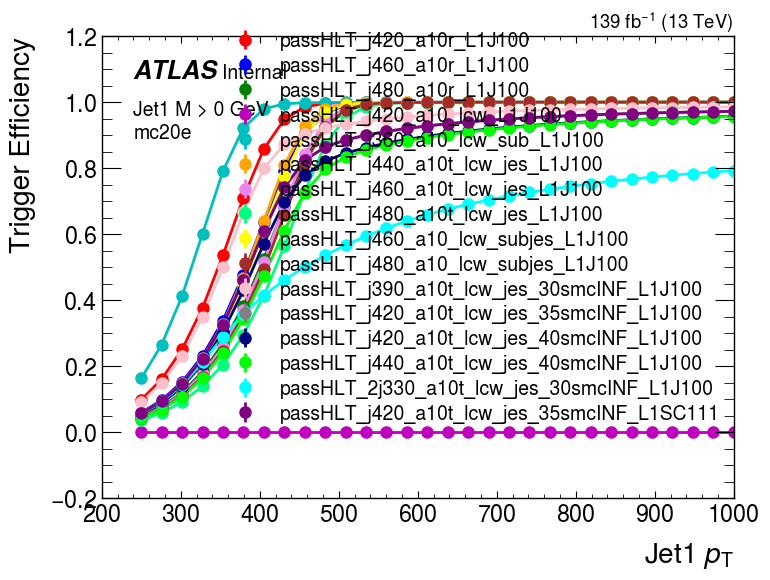

In [5]:
trigger_efficiency_pT(input_path="*20e*36470*/*.root",textlabel="mc20e")

# Efficiency vs M

In [ ]:
pT_cut = 400

def load_data_with_cuts_M(file_paths):
    jet1_pt_list = []
    pass_hlt_dict = {}
    nMuons_list = []
    nLargeRJets_list = []
    Jet1_M_list = []
    weights_list = []

    for file_path in file_paths:
        # Open the ROOT file and read the tree
        file = uproot.open(file_path)
        tree = file["Nominal"]

        # Read the necessary branches
        jet1_pt = tree["Jet1_pT"].array(library="np")
        nMuons = tree["nMuons"].array(library="np")
        nLargeRJets = tree["nLargeRJets"].array(library="np")
        Jet1_M = tree["Jet1_M"].array(library="np")
        weights = tree["weight"].array(library="np")  # Adjust this to your weight branch name

        # Define selection cuts (e.g., nMuons > 0 and Jet1_M > 100)
        selection_mask = (nMuons >= 0) & (jet1_pt > pT_cut)

        # Apply the selection mask to the data
        jet1_pt_list.append(jet1_pt[selection_mask])
        nMuons_list.append(nMuons[selection_mask])
        nLargeRJets_list.append(nLargeRJets[selection_mask])
        Jet1_M_list.append(Jet1_M[selection_mask])
        weights_list.append(weights[selection_mask])

        # Read all branches starting with "passHLT_" and apply the mask
        for branch in tree.keys():
            if branch.startswith("passHLT_"):
                if "_" not in branch:
                #if "INF" not in branch:
                    continue # Skip branches that do not contain "INF"
                else:    
                    if branch not in pass_hlt_dict:
                        pass_hlt_dict[branch] = []
                    pass_hlt_dict[branch].append(tree[branch].array(library="np")[selection_mask])

    # Combine arrays from different files
    jet1_M = np.concatenate(Jet1_M_list)
    weights = np.concatenate(weights_list)

    for key in pass_hlt_dict.keys():
        pass_hlt_dict[key] = np.concatenate(pass_hlt_dict[key])

    return jet1_M, weights, pass_hlt_dict


In [ ]:
def calculate_efficiency_M(pass_hlt, jet1_M,weights, thresholds):
    efficiency = []
    lower_errors = []
    upper_errors = []

    for threshold in thresholds:
        #passing_events = np.sum((jet1_pt > threshold) & (pass_hlt == 1))
        #total_events = np.sum(jet1_pt > threshold)
        
        selection_mask = jet1_M > threshold
        passing_mask = (jet1_M > threshold) & (pass_hlt == 1)

        total_events = np.sum(weights[selection_mask])
        passing_events = np.sum(weights[passing_mask])        
        
        
        if total_events > 0:
            eff = passing_events / total_events
            #err = np.sqrt(eff * (1 - eff) / total_events)
            #efficiency.append(eff)
            #errors.append(err)
            lower, upper = clopper_pearson_interval(passing_events, total_events)
            efficiency.append(eff)
            lower_errors.append(eff - lower)
            upper_errors.append(upper - eff)
            
        else:
            efficiency.append(0)
            #errors.append(0)
            lower_errors.append(0)
            upper_errors.append(0)

    return np.array(efficiency),np.array(lower_errors), np.array(upper_errors)


In [ ]:
def trigger_efficiency_M(input_path,textlabel):
    # Set the ATLAS Style
    hep.style.use("ATLAS")

    # Specify the base path directly
    base_path = "/fs/ddn/sdf/group/atlas"

    # If input_path is a directory, find all matching .root files
    if os.path.isdir(os.path.join(base_path, input_path)):
        file_paths = glob.glob(os.path.join(base_path, input_path, "*.root"))
    else:
        file_paths = [os.path.join(base_path, input_path)]

    # Load data from ROOT files with selection cuts
    jet1_M,weights, pass_hlt_dict = load_data_with_cuts_M(file_paths)

    # Define thresholds for Jet1_pT
    thresholds = np.linspace(0, 500, 30)

    # Create a directory to store the efficiency plots
    os.makedirs("efficiency_plots_jet1_M_INF", exist_ok=True)

    # Colors for different triggers
    colors = ['r', 'b', 'g', 'm', 'c', 'orange', 'violet', 'springgreen', 
              'yellow', 'brown', 'pink', 'grey', 'navy', 'lime', 'cyan', 
              'purple', 'teal', 'gold', 'darkred', 'lightblue']
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot efficiency for each passHLT branch containing "INF"
    for idx, (branch, pass_hlt) in enumerate(pass_hlt_dict.items()):
        #if "INF" in branch:
        if "_" in branch: #trick to plot all triggers
            
            
            #efficiency, errors = calculate_efficiency_pT(pass_hlt, jet1_pt, weights, thresholds)
            efficiency, lower_errors, upper_errors = calculate_efficiency_M(pass_hlt, jet1_M, weights, thresholds)
            
            # Plot the graph with markers and error bars
            color = colors[idx % len(colors)]
            ax.errorbar(thresholds, efficiency, yerr=[lower_errors, upper_errors], fmt='o', label=f'{branch}', color=color)

            # Plot the line through the points
            ax.plot(thresholds, efficiency, color=color)

    # Set axis titles
    ax.set_xlabel("Jet1 M [GeV]")
    ax.set_ylabel('Trigger Efficiency')

    # Add the ATLAS Label
    #hep.atlas.text("Internal", loc=1)
    hep.atlas.label(loc=1,data='true',label="Internal",lumi=139)

    #ax.text(0.2, 0.86, "#sqrt{s} = 13 TeV, 139 fb^{-1}", fontsize=12, transform=ax.transAxes)

    
    # Add the mass cut text
    #ax.text(0.2, 0.80, f"Mass Cut: nMuons >= 0 & Jet1_M > {mass_cut}", fontsize=12, transform=ax.transAxes)
    ax.text(0.05, 0.83, f"Jet1 $p_T$ > {pT_cut} GeV", fontsize=14, transform=ax.transAxes)
    ax.text(0.05, 0.78, f"{textlabel}", fontsize=14, transform=ax.transAxes)

    
    # Add legend
    ax.legend(bbox_to_anchor=(0.15, 0.10,0.3,0.3),fontsize=14,loc='lower left')
    #ax.legend(bbox_to_anchor=(0.55, 0.2, 0.85, 0.6),fontsize=14)

    # Save the plot as a PDF
    plt.savefig("efficiency_plots_jet1_M_INF/INF_triggers.pdf")

    print("Efficiency plots saved in the 'efficiency_plots_jet1_pT_INF' directory.")


## mc20a


In [ ]:
trigger_efficiency_M(input_path="*20a*36470*/*.root",textlabel="mc20a")

## mc20d


In [ ]:
trigger_efficiency_M(input_path="*20d*36470*/*.root",textlabel="mc20d")



## mc20e




In [ ]:
trigger_efficiency_M(input_path="*20e*36470*/*.root",textlabel="mc20e")